# Exploratory Data Analysis
## 1. Calculate and explore target variable (player improvement)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('fivethirtyeight')
pd.set_option('display.max_columns', None)

In [2]:
data = pd.read_csv('data/clean_data.csv')
data.head()

,Year,Player,Pos,Age,Tm,G,TS%,3PAr,FTr,TRB%,AST%,STL%,BLK%,TOV%,USG%,WS,WS/48,3P%,FT%,Pick,GS%,FGA/48,PF/48,MPG
0,1980.0,Abdul Jeelani,SF,25.0,POR,77.0,0.563,0.011,0.361,11.5,11.6,1.5,1.8,15.2,24.6,3.8,0.141,0.050,0.789,61.0,0.345292,21.088647,5.785381,16.701299
1,1980.0,Adrian Dantley,SF,23.0,UTA,68.0,0.635,0.002,0.415,11.3,12.3,1.8,0.3,13.5,27.8,10.5,0.189,0.050,0.842,6.0,0.812997,22.743455,3.787584,39.323529
2,1980.0,Alex English,SF,26.0,IND,78.0,0.536,0.005,0.239,13.1,13.9,1.4,1.4,14.8,23.4,5.3,0.105,0.050,0.789,23.0,0.636405,22.250729,4.118284,30.782051
3,1980.0,Allan Bristow,SF,28.0,UTA,82.0,0.534,0.009,0.310,13.0,21.4,1.9,0.1,16.7,20.0,4.4,0.091,0.050,0.811,21.0,0.580905,16.354167,4.395833,28.097561
4,1980.0,Allen Leavell,PG,22.0,HOU,77.0,0.560,0.029,0.337,4.8,26.3,2.8,0.7,21.4,17.8,4.0,0.091,0.158,0.814,61.0,0.570027,14.831842,4.454074,27.571429


There are several features that summarize a player's overall performance. Among them, [WS(win share)](https://www.basketball-reference.com/about/ws.html) is the most interpretable and among the most accurate measures. Win share means how many wins a player contributed to the team(s). It takes account how good a player is when he is on the floor, and how many minutes he played (an injured good player doesn't contribute anything to the team).<br>
So, I define the improvement of a player at a particular year as WS(year)-WS(year-1). However, I am trying to predict next year's improvement, so:<br>
**Improvement_next_season(year) = WS(year+1) - WS(year)**

In [3]:
# Function to calculate improvement
def calculate_diff_with_next_year(df, col):
    diff = dict()
    for index, row in df.iterrows():
        year = row['Year']
        # Check to see if stats for next year exists
        if year+1 in df['Year'].values:
            diff[year] = float(df.loc[df['Year']==year+1, col] - row[col])
        else:
            diff[year] = np.nan
    return pd.Series(diff)
# Calculate improvement and create DataFrame
improvement = data.groupby('Player').apply(calculate_diff_with_next_year, col='WS')
improvement = pd.DataFrame(improvement).reset_index()
improvement.columns = ['Player', 'Year', 'Improvement']
# Merge into the main dataset
data = pd.merge(data, improvement, on=['Player', 'Year'], how='inner')
# Drop years without target values
data.dropna(inplace=True)

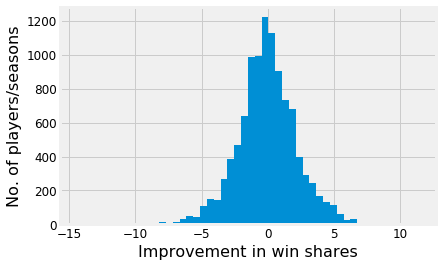

In [4]:
# Check the distribution of improvement
_ = plt.hist(data['Improvement'], bins=50)
_ = plt.xlabel('Improvement in win shares', fontsize=16)
_ = plt.ylabel('No. of players/seasons', fontsize=16)
_ = plt.xticks(fontsize=12)
_ = plt.yticks(fontsize=12)

Approximately normal distribution centered around 0.<br>
There is a Most Improved Player Award in the NBA, let's see if the winners were actually the most improved, or close to be each year. While the awards were given based on people's opinion, not data, it should be generally consistent with our calculation of improvement. 

In [5]:
# Grab the list of Most Improved Player Award winners from the internet.
# Use code adapted from data wrangling section (changes to fit this specific webpage)
url = 'https://www.basketball-reference.com/awards/mip.html'
import requests
import lxml.html as lh
# Read the page
page = requests.get(url)
doc = lh.fromstring(page.content)
# Extract tables
tr_elements = doc.xpath('//tr')
# Skip first row, which is an extra header
tr_elements.pop(0)
# Extract column names
cols = [t.text_content() for t in tr_elements[0]]
tr_elements.pop(0)
# Read the rows
cols_data = [[] for i in cols]
for row in tr_elements:
    # Only the read the table that is of same columns as the first one (There are two tables on the page)
    if len(row) != len(cols):
        continue
    # Read the columns in each row
    for col_index, col in enumerate(row.iterchildren()):
            col_text = col.text_content()
            #try to convert to numbers
            try:
                if col_text == '':
                    num = np.nan
                else:
                    num = float(col_text)
                cols_data[col_index].append(num)
            except:
                cols_data[col_index].append(col_text)
# Make a dataframe
mip = pd.DataFrame(dict(zip(cols, cols_data)), columns=cols)
mip.head()

,Season,Lg,Player,Voting,Age,Tm,G,MP,PTS,TRB,AST,STL,BLK,FG%,3P%,FT%,WS,WS/48
0,2017-18,NBA,Victor Oladipo,(V),25.0,IND,75.0,34.0,23.1,5.2,4.3,2.4,0.8,0.477,0.371,0.799,8.3,0.155
1,2016-17,NBA,Giannis Antetokounmpo,(V),22.0,MIL,80.0,35.6,22.9,8.8,5.4,1.6,1.9,0.521,0.272,0.770,12.4,0.210
2,2015-16,NBA,CJ McCollum,(V),24.0,POR,80.0,34.8,20.8,3.2,4.3,1.2,0.3,0.448,0.417,0.827,6.0,0.104
3,2014-15,NBA,Jimmy Butler,(V),25.0,CHI,65.0,38.7,20.0,5.8,3.3,1.8,0.6,0.462,0.378,0.834,11.2,0.214
4,2013-14,NBA,Goran Dragic,(V),27.0,PHO,76.0,35.1,20.3,3.2,5.9,1.4,0.3,0.505,0.408,0.760,10.3,0.186


In [6]:
# We only need the Season and Player columns
mip = mip[['Season', 'Player']]
mip.columns = ['Year', 'Player']
# Edit the year label to the same format as our main dataset
mip['Year'] = mip['Year'].map(lambda x:x[:4]).astype(int)
# Fix a small name formatting issue
mip = mip.replace('CJ McCollum', 'C.J. McCollum')
mip.head()

,Year,Player
0,2017,Victor Oladipo
1,2016,Giannis Antetokounmpo
2,2015,C.J. McCollum
3,2014,Jimmy Butler
4,2013,Goran Dragic


In [7]:
# Calculate the number of players with improvement scores each year
player_sizes = improvement.dropna().groupby('Year').size()
player_sizes.name = 'No. of Players'
mip = mip.join(player_sizes, on='Year')
# Calculate rank of improvement scores
improvement['Rank'] = improvement.groupby('Year')['Improvement'].rank()
# Merge these info
mip = pd.merge(mip, improvement, on=['Year','Player'], how='left')
mip.head()

,Year,Player,No. of Players,Improvement,Rank
0,2017,Victor Oladipo,319,4.3,313.5
1,2016,Giannis Antetokounmpo,326,5.3,324.0
2,2015,C.J. McCollum,339,4.2,330.0
3,2014,Jimmy Butler,337,4.1,328.0
4,2013,Goran Dragic,325,4.6,316.0


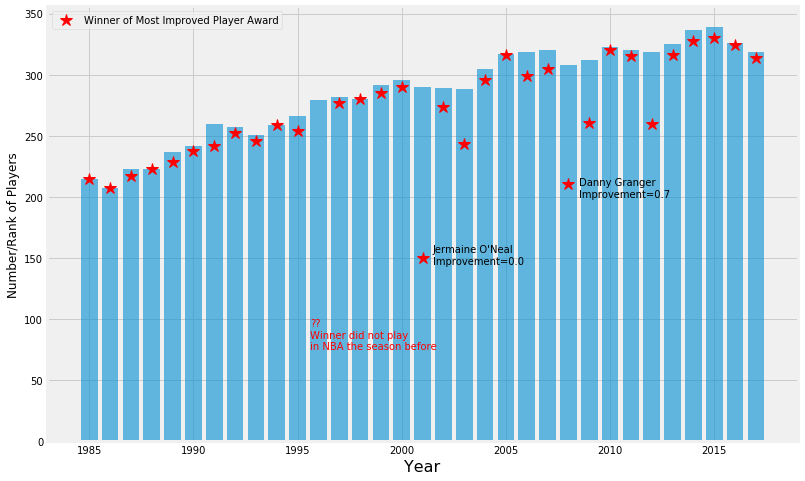

In [8]:
# Plot each year's player numbers and the winner's rank.
_ = plt.figure(figsize=(12,8))
_ = plt.bar(mip['Year'], mip['No. of Players'], alpha=0.6)
_ = plt.xlabel('Year', fontsize=16)
_ = plt.ylabel('Number/Rank of Players')
_ = plt.plot(mip['Year'], mip['Rank'], 'r*', ms=12, label='Winner of Most Improved Player Award')
_ = plt.legend()
# Add annotation for a few outliers
_ = plt.text(2001.5, 145, '{}\nImprovement={:.1f}'.\
                          format(mip.loc[mip.Year==2001,'Player'].values[0], 
                                 mip.loc[mip.Year==2001,'Improvement'].values[0]))
_ = plt.text(2008.5, 200, '{}\nImprovement={:.1f}'.\
                          format(mip.loc[mip.Year==2008,'Player'].values[0], 
                                 mip.loc[mip.Year==2008,'Improvement'].values[0]))
_ = plt.text(1995.6, 75, '??\nWinner did not play\nin NBA the season before', color='r')

Generally, the winners were among the most improved players, so we should be OK using this improvement measurement. Sometimes, the award winners were not among the most improved, see in 2001 and 2008 (discussion of those seasons for another time). But I am not trying to predict who will win the award, I am trying to predict improvement for all players. While this was a fun visulization, it doesn't change how I build models here.

## 2. Relationships between improvement and various features
### 2.1 Hypothesis: Younger players improve; older player regress.

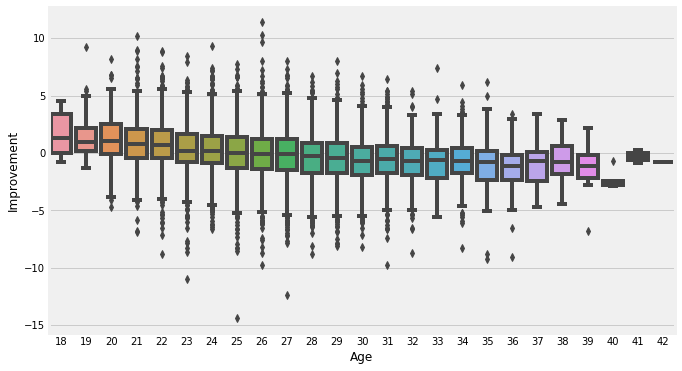

In [9]:
data['Age'] = data['Age'].astype(int)
_ = plt.figure(figsize=(10,6))
_ = sns.boxplot(x='Age', y='Improvement', data=data)

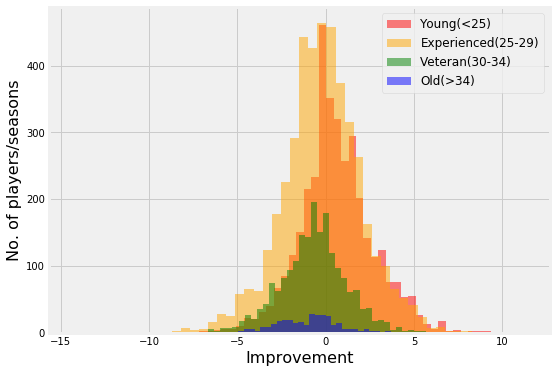

In [10]:
# A different view
# Separate players into Young(<25), Experienced(25-29), Veteran(30-34) and Old(>34).
young = data.loc[data['Age']<25, 'Improvement']
experienced = data.loc[(data['Age']>=25) & (data['Age']<30), 'Improvement']
veteran = data.loc[(data['Age']>=30) & (data['Age']<35), 'Improvement']
old = data.loc[data['Age']>=35, 'Improvement']
plot_data = [young, experienced, veteran, old]
labels = ['Young(<25)', 'Experienced(25-29)', 'Veteran(30-34)', 'Old(>34)']
colors = ['red', 'orange', 'green', 'blue']
# Histogram
_ = plt.figure(figsize=(8,6))
for group, label, color in zip(plot_data, labels, colors):
    _ = plt.hist(group, bins=50, alpha=0.5, label=label, color=color)
_ = plt.xlabel('Improvement', fontsize=16)
_ = plt.ylabel('No. of players/seasons', fontsize=16)
_ = plt.legend(fontsize=12)

In [11]:
# z-test function
def ztest(d1, d2, label):
    from statsmodels.stats.weightstats import CompareMeans
    test_data = CompareMeans.from_data(d1, d2)
    z, p = CompareMeans.ztest_ind(test_data)
    print('For {}, z = {}, p = {}'.format(label,z,p))

In [12]:
# z-test
from statsmodels.stats.weightstats import CompareMeans
for g1, g2, label in [
        (young, experienced, 'Young vs Experienced'),
        (experienced, veteran, 'Experienced vs Veteran'),
        (veteran, old, 'Veteran vs Old')]:
    ztest(g1,g2,label)

For Young vs Experienced, z = 15.697576997464138, p = 1.5712991426070391e-55
For Experienced vs Veteran, z = 8.309885099594556, p = 9.579478318550364e-17
For Veteran vs Old, z = 3.1061229016920855, p = 0.001895579123910012


Yes, It does appear younger players were more likely to improve than older players. However, the differences between age groups were statistically significant but small. The variance of improvement in players of the same age were very large. So age alone is not going to be enough for a strong model.<br>

### 2.2 Hypothesis: Great players don't have much room to improve; mediocre players can improve.

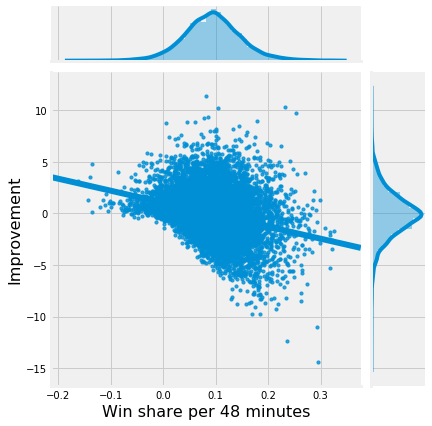

In [13]:
# Plot improvement against WS/48 (a measure of how good a player is when he is on the floor)
_ = sns.jointplot(x='WS/48', y='Improvement', data=data, kind='reg', scatter_kws={'s':10})
_ = plt.xlabel('Win share per 48 minutes', fontsize=16)
_ = plt.ylabel('Improvement', fontsize=16)

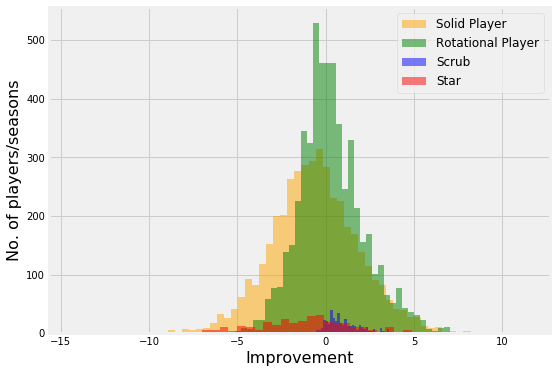

In [14]:
# There appeared to be a negative relationship between the two features.
# We also learned that WS/48 is normally distriuted around 0.1.
# Separate players into Star(WS>0.2), Solid(WS=0.1-0.2), Rotation(WS=0-0.1) and Scrub(WS<0).
star = data.loc[data['WS/48']>0.2, 'Improvement']
solid = data.loc[(data['WS/48']<=0.2) & (data['WS/48']>0.1), 'Improvement']
rotation = data.loc[(data['WS/48']<=0.1) & (data['WS/48']>0), 'Improvement']
scrub = data.loc[data['WS/48']<=0, 'Improvement']
plot_data = [solid, rotation, scrub, star]
labels = ['Solid Player', 'Rotational Player', 'Scrub', 'Star']
colors = ['orange', 'green', 'blue', 'red']
# Histogram
_ = plt.figure(figsize=(8,6))
for group, label, color in zip(plot_data, labels, colors):
    _ = plt.hist(group, bins=50, alpha=0.5, label=label, color=color)
_ = plt.xlabel('Improvement', fontsize=16)
_ = plt.ylabel('No. of players/seasons', fontsize=16)
_ = plt.legend(fontsize=12)

In [15]:
# z-test
for g1, g2, label in [
        (star, solid, 'Star vs Solid Player'),
        (solid, rotation, 'Solid Player vs Rotational Player'),
        (rotation, scrub, 'Rotational Player vs Scrub')]:
    ztest(g1,g2,label)

For Star vs Solid Player, z = -4.799111607353545, p = 1.5937097091657813e-06
For Solid Player vs Rotational Player, z = -20.780161719061372, p = 6.543784856757284e-96
For Rotational Player vs Scrub, z = -9.902999263122858, p = 4.039745893012583e-23


It appeared that the hypothesis was true. It is necessary to realize that there was some survival bias here. It appeared that bad players were more likely to improve. However, bad players that didn't improve could have been out of NBA by the next year, so he didn't appear in the dataset. So it is important to recognize that we are only analyzing players that are still in the NBA the next season.<br>
### 2.3 Hypothesis: A good player with limited playing time is more likely to improve than a good starter.
If a team recognize a player's positive contribution during his limited time, he is likely to get more playing time, and therefore increase his production and/or improve his skills. On the other hand, if a good player is already a starter, he is already playing heavy minutes and can't get more playing time. 

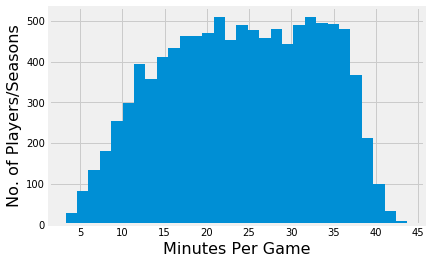

In [16]:
# From analysis above, we can categorize good players as having WS/48>=0.1
# Let's look at distribution of playing time
_ = plt.hist(data['MPG'], bins=30)
_ = plt.xlabel('Minutes Per Game', fontsize=16)
_ = plt.ylabel('No. of Players/Seasons', fontsize=16)

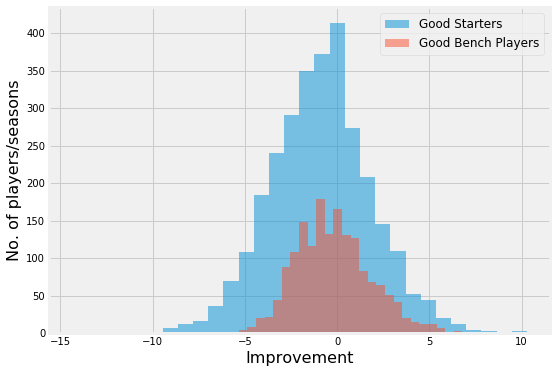

In [17]:
# Separate data into good starters and good bench
good_starters = data.loc[(data['WS/48']>=0.1) & (data['MPG']>25), 'Improvement']
good_bench = data.loc[(data['WS/48']>=0.1) & (data['MPG']<=25), 'Improvement']
_ = plt.figure(figsize=(8,6))
_ = plt.hist(good_starters, bins=30, alpha=0.5, label='Good Starters')
_ = plt.hist(good_bench, bins=30, alpha=0.5, label='Good Bench Players')
_ = plt.xlabel('Improvement', fontsize=16)
_ = plt.ylabel('No. of players/seasons', fontsize=16)
_ = plt.legend(fontsize=12)

In [18]:
ztest(good_starters, good_bench, 'Good Starters vs Good Bench')
print('The average improvement for good starters were', good_starters.mean())
print('The average improvement for good bench players were', good_bench.mean())

For Good Starters vs Good Bench, z = -9.40454460687411, p = 5.225599842600068e-21
The average improvement for good starters were -0.8840083566589588
The average improvement for good bench players were -0.16050433157194752


Even though the differences were statistically significant, the actual difference in improvements were small (~0.7). Whether a player is a starter or not had limited impact on their improvement.<br>
### 2.4 Hypothesis: A good player who missed significant time tend to rebound the next season.
A good player who played much less than 82 games likely suffered an injury or two. More often than not, they come back next season healthy and generate much more wins than this season.

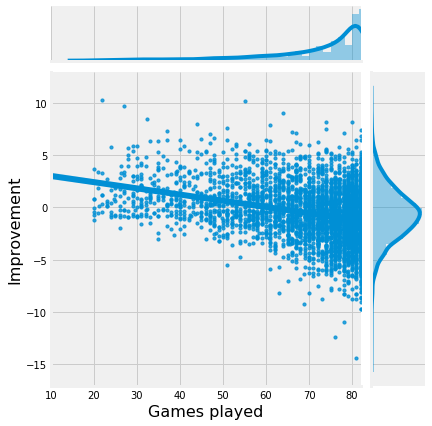

In [19]:
good_players = data.loc[(data['WS/48']>=0.1)]
_ = sns.jointplot(x='G', y='Improvement', data=good_players, kind='reg', scatter_kws={'s':10})
_ = plt.xlim([10,82])
_ = plt.xlabel('Games played', fontsize=16)
_ = plt.ylabel('Improvement', fontsize=16)

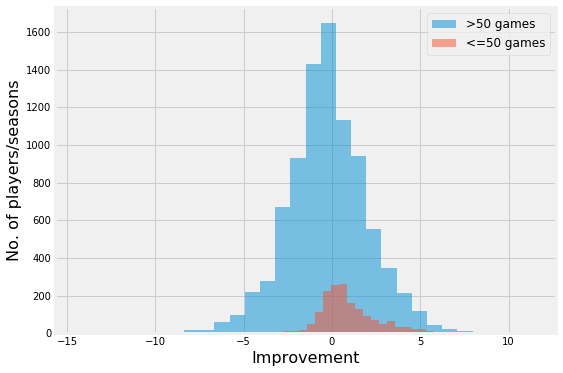

In [20]:
# Separate those played >50 games and those played <=50 games
more_than_50games = data.loc[(data['G']>50) & (data['WS/48']), 'Improvement']
less_than_50games = data.loc[(data['G']<=50) & (data['WS/48']), 'Improvement']
_ = plt.figure(figsize=(8,6))
_ = plt.hist(more_than_50games, bins=30, alpha=0.5, label='>50 games')
_ = plt.hist(less_than_50games, bins=30, alpha=0.5, label='<=50 games')
_ = plt.xlabel('Improvement', fontsize=16)
_ = plt.ylabel('No. of players/seasons', fontsize=16)
_ = plt.legend(fontsize=12)

In [21]:
# Statistical tests
ztest(more_than_50games, less_than_50games, 'good players >50 games vs <=50 games')
print('Average improvement for those played more than 50 games were', more_than_50games.mean())
print('Average improvement for those played less than 50 games were', less_than_50games.mean())

For good players >50 games vs <=50 games, z = -21.789646426778596, p = 2.908878360737984e-105
Average improvement for those played more than 50 games were -0.25787451264784583
Average improvement for those played less than 50 games were 1.0234582560296843


The differences between those who played more and those who played less were statistically significant, and were ~1.3<br>
### 2.5 Hypothesis: A frontcourt player has a steeper learning curve than a backcourt player.
There is this opinion that a big man takes longer to adapt to the NBA game than a backcourt player, and therefore their improvement in the NBA is on a slower pace than backcourt players. Is this notion supported by data though?

In [22]:
# Look at player positions
data['Pos'].unique()

array(['SF', 'PG', 'C', 'SG', 'PF', 'SG-PG', 'SG-SF', 'C-PF', 'PG-SG',
       'PF-C', 'SF-PF', 'SF-SG', 'PF-SF', 'PG-SF', 'SG-PF'], dtype=object)

In [23]:
# Most of them are pretty obvious to categorize as frontcourt or backcourt.
# There were a few that were a little ambiguous, such as SF-PF, SG-PF.
# For those, I will categorize them based on how often they shoot 3s.
def front_court(row):
    frontcourt = ['C', 'PF', 'C-PF', 'PF-C']
    ambiguous = ['SF-PF', 'PF-SF', 'SG-PF']
    if row['Pos'] in ambiguous:
        # if 3-P shot rate is above 0.1, a backcourt player
        if row['3PAr'] >= 0.1:
            return 0
        else:
            return 1
    elif row['Pos'] in frontcourt:
        return 1
    else:
        return 0
data['Frontcourt'] = data.apply(front_court, axis=1)
data.drop('Pos', axis=1, inplace=True)

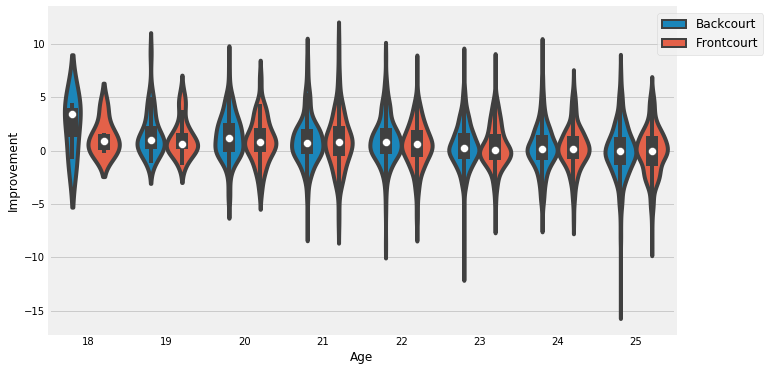

In [24]:
_ = plt.figure(figsize=(10,6))
ax = sns.violinplot(x='Age', y='Improvement', hue='Frontcourt', data=data[data.Age<=25])
handles, labels = ax.get_legend_handles_labels()
_ = plt.legend(handles[0:2],['Backcourt', 'Frontcourt'], bbox_to_anchor=(1.15, 1), fontsize=12)

In [25]:
# It seems like the hypothesis is not true for most age groups.
# Are the differences in players age 18 and 19 significant?
frontcourt = data.loc[(data['Frontcourt']==1) & (data['Age']<20), 'Improvement']
backcourt = data.loc[(data['Frontcourt']==0) & (data['Age']<20), 'Improvement']
ztest(frontcourt, backcourt, 'Young frontcourt player vs Young backcourt player')

For Young frontcourt player vs Young backcourt player, z = -0.9590185937793391, p = 0.3375493782492871


This notion of difference in growth of fontcourt and backcourt players is just not true in general.<br>
### 2.6 Hypothesis: A player's improvement of this year is correlated with his improvement last year.
One could think that a player on the rise is likely to be improving for a few years, and a player in decline is likely to get worse every year. This continuous improvement or deterioration are more often seen in younger and older players, respectively.

In [26]:
# Get a player's improvement of previous year
improvement.drop('Rank', axis=1, inplace=True)
improvement.columns = ['Player', 'Year', 'Imprv_prev_year']
improvement['Year'] += 1
data = pd.merge(data, improvement, on=['Player', 'Year'], how='left')
data.fillna(0, inplace=True)

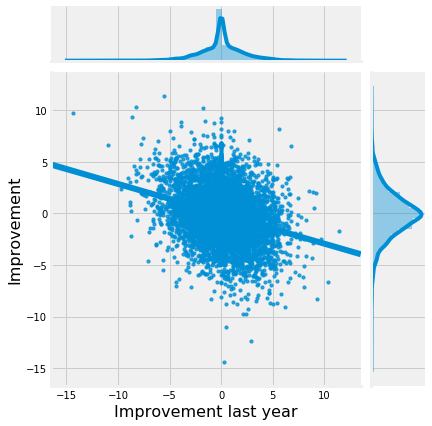

In [27]:
_ = sns.jointplot(x='Imprv_prev_year', y='Improvement', data=data, kind='reg', scatter_kws={'s':10})
_ = plt.xlabel('Improvement last year', fontsize=16)
_ = plt.ylabel('Improvement', fontsize=16)

It appears that a players's improvement is more often negatively correlated with his improvement last year. Although consecutive years of positive or negative improvement did happen for some players. What happens more often  is that a player will "regress to the mean" after changes in performance last year.<br>
### 2.7 The improvement of players drafted early are quicker and larger than those of players drafted later.
Players drafted early are generally more talented than those drafted later. Therefore, they may become good players/stars more often and faster than those drafted later.

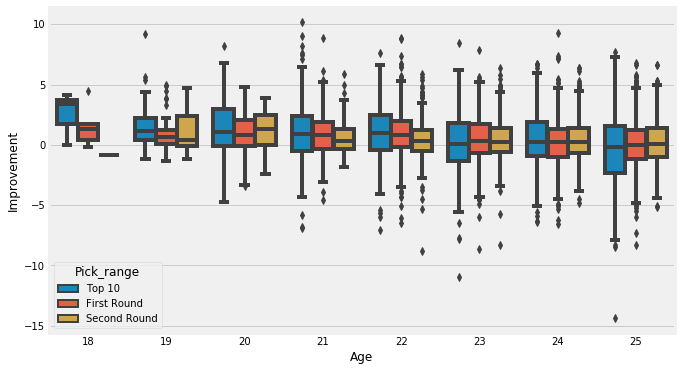

In [28]:
# There are 61 draft positions, too many to plot. Separate into groups.
def pick_range(pick):
    if pick<=10:
        return 'Top 10'
    elif pick<=30:
        return 'First Round'
    else:
        return 'Second Round'
data['Pick_range'] = data['Pick'].map(pick_range)
_ = plt.figure(figsize=(10, 6))
_ = sns.boxplot(x='Age', y='Improvement', hue='Pick_range', 
                hue_order=['Top 10','First Round','Second Round'], data=data.loc[data['Age']<=25])
data.drop('Pick_range', axis=1, inplace=True)

In [29]:
# It seems like the hypothesis is true when players are 18 or 19 years old.
# Statistical test
top10 = data.loc[(data['Pick']<=10) & (data['Age']<20), 'Improvement']
others = data.loc[(data['Pick']>10) & (data['Age']<20), 'Improvement']
test_data = CompareMeans.from_data(top10, others)
z, p = CompareMeans.ztest_ind(test_data)
print('z = {}, p = {}'.format(z,p))

z = 1.3975729102393333, p = 0.16224135796238814


Even though it looked like the hypothesis was true for younger players, the differencs were not statistically significant. So, players drafted earlier did not improve faster.<br>
### 2.7 Hypothesis: Player improvement is impacted by what kind of team he is on.

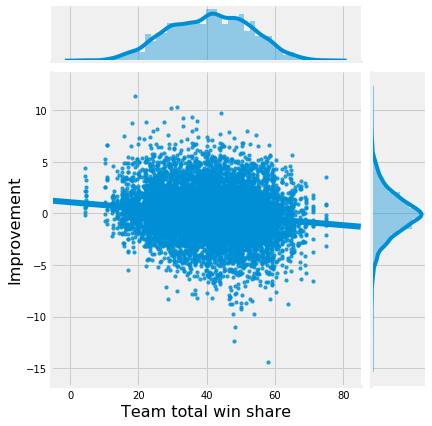

In [30]:
# First calculate sum of team win shares, as an estimate of how goood a team is.
# Read the player season stats data again.
season_stats = pd.read_csv('data/clean_data.csv')
season_stats = season_stats[['Year','Player','Tm','WS']]
team_wins = season_stats.groupby(['Year','Tm'])['WS'].sum()
team_wins = team_wins.to_frame().reset_index().rename(columns={'WS':'Tm_WS'})
# Merge team wins with main dataset
data = pd.merge(data, team_wins, on=['Year','Tm'], how='left')
_ = sns.jointplot(x='Tm_WS', y='Improvement', data=data, kind='reg', scatter_kws={'s':10})
_ = plt.xlabel('Team total win share', fontsize=16)
_ = plt.ylabel('Improvement', fontsize=16)

In [31]:
# There seem to be weak negative relationship
# Players often change teams. That could potentially have effect on player's performance.
# Extract every player's team for next year
next_season = season_stats[['Year','Player','Tm']].rename(columns={'Tm':'Tm_next'})
next_season['Year'] = next_season['Year'] - 1
# Merge this info with the main dataset
data = pd.merge(data, next_season, on=['Year', 'Player'], how='left')
data['Change_team'] = data['Tm']==data['Tm_next']

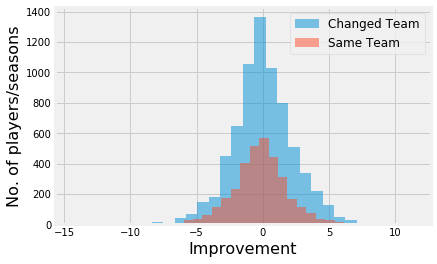

In [32]:
changed_team = data.loc[data['Change_team']==True, 'Improvement']
same_team = data.loc[data['Change_team']==False, 'Improvement']
_ = plt.hist(changed_team, bins=30, alpha=0.5, label='Changed Team')
_ = plt.hist(same_team, bins=30, alpha=0.5, label='Same Team')
_ = plt.legend(fontsize=12)
_ = plt.xlabel('Improvement', fontsize=16)
_ = plt.ylabel('No. of players/seasons', fontsize=16)

In [33]:
ztest(changed_team, same_team, 'Players that changed teams vs Players stayed on same teams')
print('Average improvement for players that changed teams were', changed_team.mean())
print('Average improvement for players that stayed on the same teams were', same_team.mean())

For Players that changed teams vs Players stayed on same teams, z = 4.4709417900006665, p = 7.787589450890515e-06
Average improvement for players that changed teams were 0.01511263997408322
Average improvement for players that stayed on the same teams were -0.19537269379371516


Although statistically significant, the difference between the two groups were very small (~0.2)

In [34]:
data.to_csv('data/modified_data.csv')